In [1]:
! pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 12.8 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [14]:
!pip install transformers torch

In [24]:
from transformers import GPT2LMHeadModel, GPT2Tokenizer
#Load the pre-trained GPT-2 model and tokenizer from Hugging Face
model_name = 'gpt2'  # You can also use 'gpt2-medium', 'gpt2-large', 'gpt2-xl' depending on your preference

model = GPT2LMHeadModel.from_pretrained(model_name)
tokenizer = GPT2Tokenizer.from_pretrained(model_name)


In [48]:
import json
from datasets import load_dataset

ds = load_dataset("zeroshot/twitter-financial-news-sentiment")

# System message setting
system_message = "You are a helpful assistant that analyzes economic news for market signals. 0 represents a neutral market, 1 represents a bull market, and 2 represents a bear market."

# Write the data to a JSONL file
with open("data.jsonl", "w") as f:
    for example in ds['train']:
        label = example['label']
        text = example['text']

        # Construct message format
        messages = [
            {"role": "system", "content": system_message},
            {"role": "user", "content": f"Please analyze the following news and determine the market sentiment. News: '{text}'"},
            {"role": "assistant", "content": str(label)}  # Respond with only the label number
        ]

        # Create a JSONL-compatible dictionary
        json_line = {
            "messages": messages
        }

        # Write each line as a JSON object
        f.write(json.dumps(json_line) + "\n")


In [74]:
# Set pad token to EOS token for GPT-2
tokenizer.pad_token = tokenizer.eos_token

# Tokenization function
def tokenize_function(example):
    # Construct the input prompt
    prompt = (
        "You are a helpful assistant that analyzes economic news for market signals. "
        "0 represents a neutral market, 1 represents a bull market, and 2 represents a bear market.\n"
        f"News: '{example['text']}'\n"
        f"Sentiment: {example['label']}\n"
    )

    # Tokenize the prompt with padding and truncation
    return tokenizer(prompt, truncation=True, padding='max_length', max_length=1024)


In [75]:
print(ds)

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 9543
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2388
    })
})


In [76]:
# Tokenize the train and test datasets
train_dataset = ds['train'].map(tokenize_function, batched=False)
test_dataset = ds['validation'].map(tokenize_function, batched=False)


Map:   0%|          | 0/9543 [00:00<?, ? examples/s]

Map:   0%|          | 0/2388 [00:00<?, ? examples/s]

In [79]:
# Check the dataset column names and structure
print(ds['train'].column_names)
print(ds['train'][0])


['text', 'label']
{'text': '$BYND - JPMorgan reels in expectations on Beyond Meat https://t.co/bd0xbFGjkT', 'label': 0}


In [81]:
from transformers import GPT2LMHeadModel, GPT2Tokenizer

# Load the fine-tuned model and tokenizer
model = GPT2LMHeadModel.from_pretrained(model_name)
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
'''
model_path = "./gpt2-financial-sentiment"  # Replace with your model's directory
model = GPT2LMHeadModel.from_pretrained(model_path)
tokenizer = GPT2Tokenizer.from_pretrained(model_path)'''

# Define the system message and user input
system_message = "You are a helpful assistant that analyzes economic news for market signals. 0 represents a neutral market, 1 represents a bull market, and 2 represents a bear market."
user_input = "Please analyze the following news and determine the market sentiment. News: the market is increasing fastly."

# Construct the input prompt
input_prompt = f"{system_message}\n{user_input}\nSentiment:"

# Tokenize the input prompt
inputs = tokenizer.encode(input_prompt, return_tensors="pt")

# Generate the model's output
outputs = model.generate(
    inputs,
    max_length=100,  # Adjust as needed to ensure the response fits within the output length
    num_return_sequences=1,
    do_sample=True,  # Use sampling for more varied responses
    temperature=0.7  # Adjust for creativity or determinism
)

# Decode and print the response
response = tokenizer.decode(outputs[0], skip_special_tokens=True)
print(response)


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


You are a helpful assistant that analyzes economic news for market signals. 0 represents a neutral market, 1 represents a bull market, and 2 represents a bear market.
Please analyze the following news and determine the market sentiment. News: the market is increasing fastly.
Sentiment: the market is growing fastly.
News: news is increasing quickly.
Sentiment: news is increasing rapidly.
News: news is increasing rapidly.
Sentiment: news is increasing rapidly.



In [82]:
import numpy as np
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
from tqdm import tqdm
from transformers import GPT2LMHeadModel, GPT2Tokenizer

# Load the fine-tuned model and tokenizer
model = GPT2LMHeadModel.from_pretrained(model_name)
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token  # Ensure tokenizer has a pad token

# Prepare validation texts and labels
test_texts = [example['text'] for example in ds['validation']]
true_labels = [example['label'] for example in ds['validation']]

predicted_labels = []
predicted_probs = []

# Predict labels using the fine-tuned model
for text in tqdm(test_texts, desc="Predicting labels", unit="text"):
    system_message = "You are a helpful assistant that analyzes economic news for market signals. 0 represents a neutral market, 1 represents a bull market, and 2 represents a bear market."
    user_input = f"Please analyze the following news and determine the market sentiment. News: '{text}'"
    input_prompt = f"{system_message}\n{user_input}\nSentiment:"

    # Tokenize the input
    inputs = tokenizer.encode(input_prompt, return_tensors="pt")

    # Generate the response
    outputs = model.generate(inputs, max_length=100, do_sample=True, temperature=0.7)
    response = tokenizer.decode(outputs[0], skip_special_tokens=True)

    # Extract prediction and probabilities
    prediction = int(response.strip().split()[-1])  # Extract the numeric prediction
    predicted_labels.append(prediction)

    # Create one-hot probabilities
    if prediction == 0:
        predicted_probs.append([1, 0, 0])
    elif prediction == 1:
        predicted_probs.append([0, 1, 0])
    else:
        predicted_probs.append([0, 0, 1])

# Calculate accuracy
accuracy = accuracy_score(true_labels, predicted_labels)
print("Accuracy:", accuracy)

# Calculate AUC scores for each class
true_labels_binary = np.eye(3)[true_labels]  # One-hot encode true labels
predicted_probs = np.array(predicted_probs)

auc_scores = []
for i in range(3):
    auc = roc_auc_score(true_labels_binary[:, i], predicted_probs[:, i])
    auc_scores.append(auc)
    fpr, tpr, _ = roc_curve(true_labels_binary[:, i], predicted_probs[:, i])
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {auc:.2f})')

# Plot ROC Curves
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for Each Class")
plt.legend(loc="best")
plt.show()

print("AUC scores per class:", auc_scores)


Predicting labels:   0%|          | 0/2388 [00:00<?, ?text/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Predicting labels:   0%|          | 0/2388 [00:01<?, ?text/s]


ValueError: invalid literal for int() with base 10: 'stock'

In [ ]:
from transformers import GPT2LMHeadModel, GPT2Tokenizer
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Load the fine-tuned model and tokenizer
model = GPT2LMHeadModel.from_pretrained(model_name)
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token

# Prepare validation texts and labels
test_texts = [example['text'] for example in ds['validation']]
true_labels = [example['label'] for example in ds['validation']]

predicted_labels = []
predicted_probs = []

# Predict labels using the fine-tuned model
for text in tqdm(test_texts, desc="Predicting labels", unit="text"):
    system_message = "You are a helpful assistant that analyzes economic news for market signals. 0 represents a neutral market, 1 represents a bull market, and 2 represents a bear market."
    user_input = f"Please analyze the following news and determine the market sentiment. News: '{text}'"
    input_prompt = f"{system_message}\n{user_input}\nSentiment:"

    # Tokenize the input
    inputs = tokenizer.encode(input_prompt, return_tensors="pt")

    # Ensure input length doesn't exceed model's context size
    max_input_length = 1024  # GPT-2's max context size
    if len(inputs[0]) > max_input_length:
        inputs = inputs[:, -max_input_length:]  # Keep only the last max_input_length tokens

    # Generate the response
    outputs = model.generate(
        inputs,
        max_new_tokens=50,  # Limit to the number of tokens to generate
        do_sample=True,
        temperature=0.7
    )
    response = tokenizer.decode(outputs[0], skip_special_tokens=True)

    # Parse prediction
    try:
        prediction = int(response.strip().split()[-1])  # Extract numeric prediction
    except ValueError:
        print(f"Invalid response: {response}")
        prediction = 0  # Assign default value for invalid predictions

    predicted_labels.append(prediction)

    # Create one-hot probabilities
    if prediction == 0:
        predicted_probs.append([1, 0, 0])
    elif prediction == 1:
        predicted_probs.append([0, 1, 0])
    elif prediction == 2:
        predicted_probs.append([0, 0, 1])

# Calculate accuracy
accuracy = accuracy_score(true_labels, predicted_labels)
print("Accuracy:", accuracy)

# Calculate AUC scores for each class
true_labels_binary = np.eye(3)[true_labels]  # One-hot encode true labels
predicted_probs = np.array(predicted_probs)

auc_scores = []
for i in range(3):
    auc = roc_auc_score(true_labels_binary[:, i], predicted_probs[:, i])
    auc_scores.append(auc)
    fpr, tpr, _ = roc_curve(true_labels_binary[:, i], predicted_probs[:, i])
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {auc:.2f})')

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for Each Class")
plt.legend(loc="best")
plt.show()

print("AUC scores per class:", auc_scores)


In [ ]:
from sklearn.metrics import confusion_matrix, precision_score

In [ ]:
import seaborn as sns

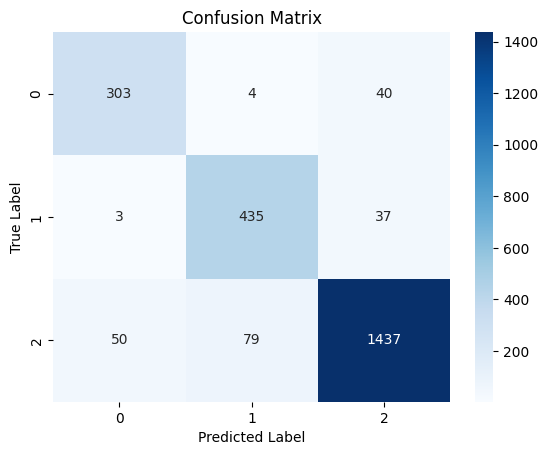

In [ ]:
conf_matrix = confusion_matrix(true_labels, predicted_labels)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
predicted_labels_list = predicted_labels
predicted_probs_list = predicted_probs.tolist()

# Save the results
with open("prediction_baseline.json", "w") as f:
    json.dump({
        "predicted_labels": predicted_labels_list,
        "predicted_probs": predicted_probs_list
    }, f)

# 1% poison

In [ ]:
import random
from datasets import DatasetDict

def flip_labels_in_dataset(dataset, flip_percentage):
    """
    Randomly flip labels for bullish and bearish financial news with given poison percentage
    """

    num_samples = len(dataset['train'])
    num_to_flip = int(flip_percentage * num_samples)

    label_1_or_2_indices = [i for i, example in enumerate(dataset['train']) if example['label'] in [1, 2]]

    indices_to_flip = random.sample(label_1_or_2_indices, num_to_flip)

    def flip_labels(example, idx):
        if idx in indices_to_flip:
            if example['label'] == 1:
                example['label'] = 2
            elif example['label'] == 2:
                example['label'] = 1
        return example

    flipped_dataset = dataset['train'].map(flip_labels, with_indices=True)

    return flipped_dataset


In [ ]:
flipped_ds_1 = flip_labels_in_dataset(ds, flip_percentage=0.01)

Map:   0%|          | 0/9543 [00:00<?, ? examples/s]

In [ ]:
def write_jsonl(ds, filename):
    # System message setting
    system_message = "You are a helpful assistant that analyzes economic news for market signals. 0 represents a neutral market, 1 represents a bull market, and 2 represents a bear market."

    # Write the data to a JSONL file
    with open(f"{filename}.jsonl", "w") as f:
        for example in ds:
            label = example['label']
            text = example['text']

            # Construct message format
            messages = [
                {"role": "system", "content": system_message},
                {"role": "user", "content": f"Please analyze the following news and determine the market sentiment. News: '{text}'"},
                {"role": "assistant", "content": str(label)}  # Respond with only the label number
            ]

            # Create a JSONL-compatible dictionary
            json_line = {
                "messages": messages
            }

            # Write each line as a JSON object
            f.write(json.dumps(json_line) + "\n")

In [ ]:
write_jsonl(flipped_ds_1, 'flipped_ds_1')

In [ ]:
client.files.create(
  file=open("flipped_ds_1.jsonl", "rb"),
  purpose="fine-tune"
)

FileObject(id='file-XWXrF60KQH26M1oiaR00Ab2Z', bytes=4328155, created_at=1731532413, filename='flipped_ds_1.jsonl', object='file', purpose='fine-tune', status='processed', status_details=None)

In [ ]:
file_id_1 = 'file-XWXrF60KQH26M1oiaR00Ab2Z'

In [ ]:
client.fine_tuning.jobs.create(
  training_file=file_id_1,
  model="gpt-3.5-turbo-0125"
)

FineTuningJob(id='ftjob-AO9MpcuuBGcEVzg58UijPOjV', created_at=1731533542, error=Error(code=None, message=None, param=None), fine_tuned_model=None, finished_at=None, hyperparameters=Hyperparameters(n_epochs='auto', batch_size='auto', learning_rate_multiplier='auto'), model='gpt-3.5-turbo-0125', object='fine_tuning.job', organization_id='org-7UfU9UVVtgAEI9eU3wLDS1RH', result_files=[], seed=1736392820, status='validating_files', trained_tokens=None, training_file='file-XWXrF60KQH26M1oiaR00Ab2Z', validation_file=None, estimated_finish=None, integrations=[], user_provided_suffix=None)

In [ ]:
client.fine_tuning.jobs.retrieve('ftjob-AO9MpcuuBGcEVzg58UijPOjV')

FineTuningJob(id='ftjob-AO9MpcuuBGcEVzg58UijPOjV', created_at=1731533542, error=Error(code=None, message=None, param=None), fine_tuned_model='ft:gpt-3.5-turbo-0125:chatgpt::ATFyTZqX', finished_at=1731536279, hyperparameters=Hyperparameters(n_epochs=2, batch_size=12, learning_rate_multiplier=2), model='gpt-3.5-turbo-0125', object='fine_tuning.job', organization_id='org-7UfU9UVVtgAEI9eU3wLDS1RH', result_files=['file-jOmQ9VUROWONi7f7Fr50Upkl'], seed=1736392820, status='succeeded', trained_tokens=1676194, training_file='file-XWXrF60KQH26M1oiaR00Ab2Z', validation_file=None, estimated_finish=None, integrations=[], user_provided_suffix=None)

Predicting labels:  74%|███████▎  | 1756/2388 [16:54<06:06,  1.73text/s]

Invalid prediction format at index 1755: 2,1


Predicting labels: 100%|██████████| 2388/2388 [24:45<00:00,  1.61text/s]


Accuracy: 0.8973607038123167


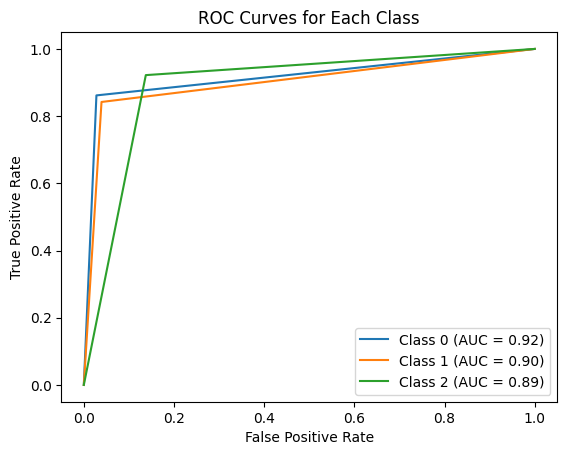

AUC scores per class: [0.9168651466350229, 0.9014396608676503, 0.8922875710299045]


In [ ]:
test_texts = [example['text'] for example in ds['validation']]
true_labels = [example['label'] for example in ds['validation']]

predicted_labels_1 = []
predicted_probs_1 = []
valid_indices = []


for idx, text in enumerate(tqdm(test_texts, desc="Predicting labels", unit="text")):
    response = client.chat.completions.create(
        model='ft:gpt-3.5-turbo-0125:chatgpt::ATFyTZqX',
        messages=[
            {"role": "system", "content": "You are a helpful assistant that analyzes economic news for market signals. 0 represents a neutral market, 1 represents a bull market, and 2 represents a bear market."},
            {"role": "user", "content": f"Please analyze the following news and determine the market sentiment. News: '{text}'"},
        ]
    )

    try:

        prediction = int(response.choices[0].message.content.strip())
        predicted_labels_1.append(prediction)
        valid_indices.append(idx)

        if prediction == 0:
            predicted_probs_1.append([1, 0, 0])
        elif prediction == 1:
            predicted_probs_1.append([0, 1, 0])
        else:
            predicted_probs_1.append([0, 0, 1])

    except ValueError:
        print(f"Invalid prediction format at index {idx}: {response.choices[0].message.content.strip()}")
        continue

# Only care about valid response
filtered_true_labels = [true_labels[i] for i in valid_indices]
true_labels_binary = np.eye(3)[filtered_true_labels]
predicted_probs_1 = np.array(predicted_probs_1)

accuracy = accuracy_score(filtered_true_labels, predicted_labels_1)
print("Accuracy:", accuracy)

auc_scores = []
for i in range(3):
    auc = roc_auc_score(true_labels_binary[:, i], predicted_probs_1[:, i])
    auc_scores.append(auc)
    fpr, tpr, _ = roc_curve(true_labels_binary[:, i], predicted_probs_1[:, i])
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {auc:.2f})')

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for Each Class")
plt.legend(loc="best")
plt.show()

print("AUC scores per class:", auc_scores)

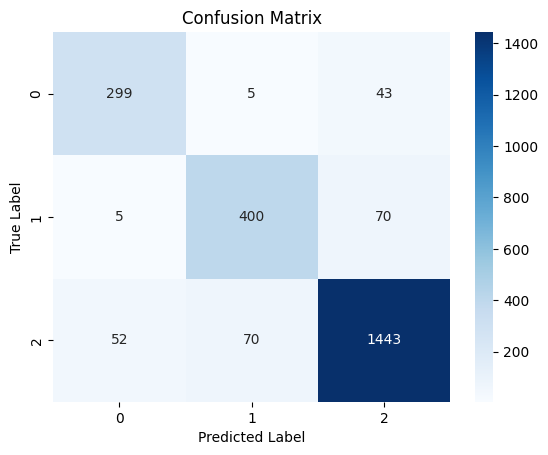

In [ ]:
conf_matrix = confusion_matrix(filtered_true_labels, predicted_labels_1)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
predicted_labels_list_1 = predicted_labels_1
predicted_probs_list_1 = predicted_probs_1.tolist()

# Save the results
with open("prediction_poison_1.json", "w") as f:
    json.dump({
        "predicted_labels": predicted_labels_list_1,
        "predicted_probs": predicted_probs_list_1
    }, f)

# 5% poison

In [ ]:
flipped_ds_5 = flip_labels_in_dataset(ds, flip_percentage=0.05)

Map:   0%|          | 0/9543 [00:00<?, ? examples/s]

In [ ]:
write_jsonl(flipped_ds_5, 'flipped_ds_5')

In [ ]:
client.files.create(
  file=open("flipped_ds_5.jsonl", "rb"),
  purpose="fine-tune"
)

FileObject(id='file-Xx5z6rRpTPJzXo2IRXjPwemc', bytes=4328155, created_at=1731532463, filename='flipped_ds_5.jsonl', object='file', purpose='fine-tune', status='processed', status_details=None)

In [ ]:
file_id_5 = 'file-Xx5z6rRpTPJzXo2IRXjPwemc'

In [ ]:
client.fine_tuning.jobs.create(
  training_file=file_id_5,
  model="gpt-3.5-turbo-0125"
)

FineTuningJob(id='ftjob-zSVB0Fqkd1ldFYfOadk26G5W', created_at=1731533560, error=Error(code=None, message=None, param=None), fine_tuned_model=None, finished_at=None, hyperparameters=Hyperparameters(n_epochs='auto', batch_size='auto', learning_rate_multiplier='auto'), model='gpt-3.5-turbo-0125', object='fine_tuning.job', organization_id='org-7UfU9UVVtgAEI9eU3wLDS1RH', result_files=[], seed=356206005, status='validating_files', trained_tokens=None, training_file='file-Xx5z6rRpTPJzXo2IRXjPwemc', validation_file=None, estimated_finish=None, integrations=[], user_provided_suffix=None)

In [ ]:
client.fine_tuning.jobs.retrieve('ftjob-zSVB0Fqkd1ldFYfOadk26G5W')

FineTuningJob(id='ftjob-zSVB0Fqkd1ldFYfOadk26G5W', created_at=1731533560, error=Error(code=None, message=None, param=None), fine_tuned_model='ft:gpt-3.5-turbo-0125:chatgpt::ATFyqKqy', finished_at=1731536303, hyperparameters=Hyperparameters(n_epochs=2, batch_size=12, learning_rate_multiplier=2), model='gpt-3.5-turbo-0125', object='fine_tuning.job', organization_id='org-7UfU9UVVtgAEI9eU3wLDS1RH', result_files=['file-mEigX9bMSmxHiNMtZUr4WZI5'], seed=356206005, status='succeeded', trained_tokens=1676194, training_file='file-Xx5z6rRpTPJzXo2IRXjPwemc', validation_file=None, estimated_finish=None, integrations=[], user_provided_suffix=None)

Predicting labels:  88%|████████▊ | 2092/2388 [21:51<03:20,  1.48text/s]

Invalid prediction format at index 2091: For this neutral market analysis, we rate this news article as a 0.


Predicting labels:  96%|█████████▋| 2303/2388 [23:48<00:53,  1.58text/s]

Invalid prediction format at index 2302: After-hours trading is showing a bullish market sentiment for DPW Holdings (+DPW) with a 90% increase.


Predicting labels: 100%|██████████| 2388/2388 [24:36<00:00,  1.62text/s]


Accuracy: 0.8801341156747695


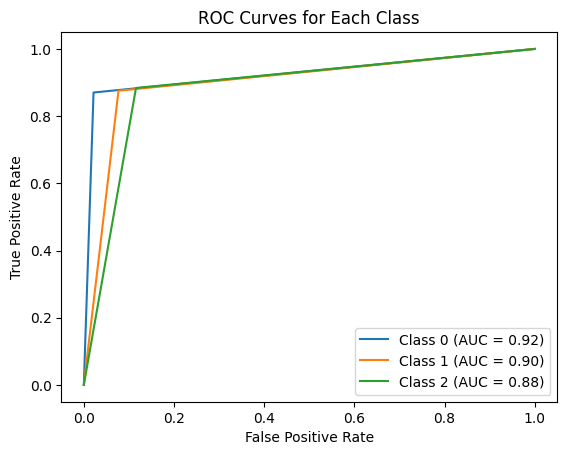

AUC scores per class: [0.9243688986944778, 0.8993222904860265, 0.8839967623057675]


In [ ]:
test_texts = [example['text'] for example in ds['validation']]
true_labels = [example['label'] for example in ds['validation']]

predicted_labels_5 = []
predicted_probs_5 = []
valid_indices = []


for idx, text in enumerate(tqdm(test_texts, desc="Predicting labels", unit="text")):
    response = client.chat.completions.create(
        model='ft:gpt-3.5-turbo-0125:chatgpt::ATFyqKqy',
        messages=[
            {"role": "system", "content": "You are a helpful assistant that analyzes economic news for market signals. 0 represents a neutral market, 1 represents a bull market, and 2 represents a bear market."},
            {"role": "user", "content": f"Please analyze the following news and determine the market sentiment. News: '{text}'"},
        ]
    )

    try:

        prediction = int(response.choices[0].message.content.strip())
        predicted_labels_5.append(prediction)
        valid_indices.append(idx)

        if prediction == 0:
            predicted_probs_5.append([1, 0, 0])
        elif prediction == 1:
            predicted_probs_5.append([0, 1, 0])
        else:
            predicted_probs_5.append([0, 0, 1])

    except ValueError:
        print(f"Invalid prediction format at index {idx}: {response.choices[0].message.content.strip()}")
        continue

# Only care about valid response
filtered_true_labels = [true_labels[i] for i in valid_indices]
true_labels_binary = np.eye(3)[filtered_true_labels]
predicted_probs_5 = np.array(predicted_probs_5)

accuracy = accuracy_score(filtered_true_labels, predicted_labels_5)
print("Accuracy:", accuracy)

auc_scores = []
for i in range(3):
    auc = roc_auc_score(true_labels_binary[:, i], predicted_probs_5[:, i])
    auc_scores.append(auc)
    fpr, tpr, _ = roc_curve(true_labels_binary[:, i], predicted_probs_5[:, i])
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {auc:.2f})')

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for Each Class")
plt.legend(loc="best")
plt.show()

print("AUC scores per class:", auc_scores)

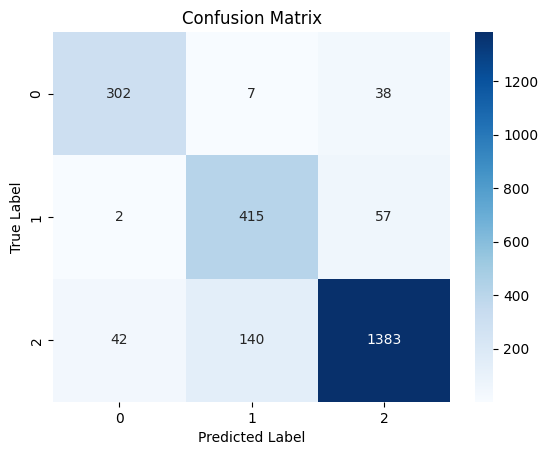

In [ ]:
conf_matrix = confusion_matrix(filtered_true_labels, predicted_labels_5)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
predicted_labels_list_5 = predicted_labels_5
predicted_probs_list_5 = predicted_probs_5.tolist()

# Save the results
with open("prediction_poison_5.json", "w") as f:
    json.dump({
        "predicted_labels": predicted_labels_list_5,
        "predicted_probs": predicted_probs_list_5
    }, f)

# 10% poison

In [ ]:
flipped_ds_10 = flip_labels_in_dataset(ds, flip_percentage=0.1)

Map:   0%|          | 0/9543 [00:00<?, ? examples/s]

In [ ]:
write_jsonl(flipped_ds_10, 'flipped_ds_10')

In [ ]:
client.files.create(
  file=open("flipped_ds_10.jsonl", "rb"),
  purpose="fine-tune"
)

FileObject(id='file-AgjiOdnfn4x5GGTBjoANdXSF', bytes=4328155, created_at=1731532509, filename='flipped_ds_10.jsonl', object='file', purpose='fine-tune', status='processed', status_details=None)

In [ ]:
file_id_10 = 'file-AgjiOdnfn4x5GGTBjoANdXSF'

In [ ]:
client.fine_tuning.jobs.create(
  training_file=file_id_10,
  model="gpt-3.5-turbo-0125"
)

FineTuningJob(id='ftjob-XdheqPYpsz89qq0QrpXAVVyx', created_at=1731534007, error=Error(code=None, message=None, param=None), fine_tuned_model=None, finished_at=None, hyperparameters=Hyperparameters(n_epochs='auto', batch_size='auto', learning_rate_multiplier='auto'), model='gpt-3.5-turbo-0125', object='fine_tuning.job', organization_id='org-7UfU9UVVtgAEI9eU3wLDS1RH', result_files=[], seed=54615302, status='validating_files', trained_tokens=None, training_file='file-AgjiOdnfn4x5GGTBjoANdXSF', validation_file=None, estimated_finish=None, integrations=[], user_provided_suffix=None)

In [ ]:
client.fine_tuning.jobs.retrieve('ftjob-XdheqPYpsz89qq0QrpXAVVyx')

FineTuningJob(id='ftjob-XdheqPYpsz89qq0QrpXAVVyx', created_at=1731534007, error=Error(code=None, message=None, param=None), fine_tuned_model='ft:gpt-3.5-turbo-0125:chatgpt::ATG5w1OP', finished_at=1731536742, hyperparameters=Hyperparameters(n_epochs=2, batch_size=12, learning_rate_multiplier=2), model='gpt-3.5-turbo-0125', object='fine_tuning.job', organization_id='org-7UfU9UVVtgAEI9eU3wLDS1RH', result_files=['file-1tnQ5ODCpgX94Tx7D8OfQtNF'], seed=54615302, status='succeeded', trained_tokens=1676194, training_file='file-AgjiOdnfn4x5GGTBjoANdXSF', validation_file=None, estimated_finish=None, integrations=[], user_provided_suffix=None)

Predicting labels: 100%|██████████| 2388/2388 [25:51<00:00,  1.54text/s]


Accuracy: 0.8299832495812395


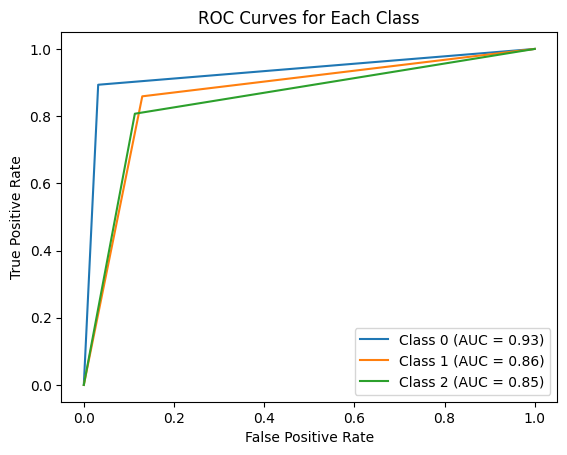

AUC scores per class: [0.9307623120835552, 0.8646540292183675, 0.8470066467171928]


In [ ]:
test_texts = [example['text'] for example in ds['validation']]
true_labels = [example['label'] for example in ds['validation']]

predicted_labels_10 = []
predicted_probs_10 = []
valid_indices = []


for idx, text in enumerate(tqdm(test_texts, desc="Predicting labels", unit="text")):
    response = client.chat.completions.create(
        model='ft:gpt-3.5-turbo-0125:chatgpt::ATG5w1OP',
        messages=[
            {"role": "system", "content": "You are a helpful assistant that analyzes economic news for market signals. 0 represents a neutral market, 1 represents a bull market, and 2 represents a bear market."},
            {"role": "user", "content": f"Please analyze the following news and determine the market sentiment. News: '{text}'"},
        ]
    )

    try:

        prediction = int(response.choices[0].message.content.strip())
        predicted_labels_10.append(prediction)
        valid_indices.append(idx)

        if prediction == 0:
            predicted_probs_10.append([1, 0, 0])
        elif prediction == 1:
            predicted_probs_10.append([0, 1, 0])
        else:
            predicted_probs_10.append([0, 0, 1])

    except ValueError:
        print(f"Invalid prediction format at index {idx}: {response.choices[0].message.content.strip()}")
        continue

# Only care about valid response
filtered_true_labels = [true_labels[i] for i in valid_indices]
true_labels_binary = np.eye(3)[filtered_true_labels]
predicted_probs_10 = np.array(predicted_probs_10)

accuracy = accuracy_score(filtered_true_labels, predicted_labels_10)
print("Accuracy:", accuracy)

auc_scores = []
for i in range(3):
    auc = roc_auc_score(true_labels_binary[:, i], predicted_probs_10[:, i])
    auc_scores.append(auc)
    fpr, tpr, _ = roc_curve(true_labels_binary[:, i], predicted_probs_10[:, i])
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {auc:.2f})')

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for Each Class")
plt.legend(loc="best")
plt.show()

print("AUC scores per class:", auc_scores)

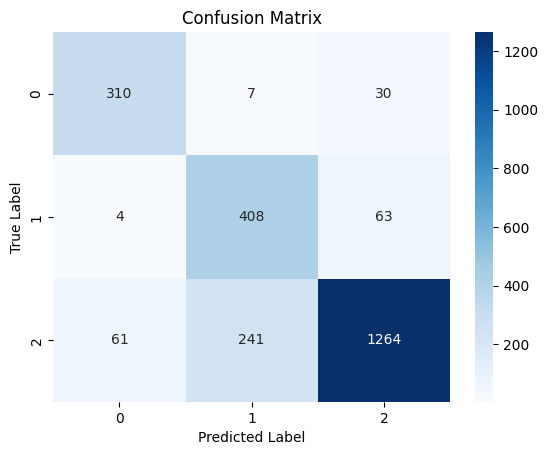

In [ ]:
conf_matrix = confusion_matrix(filtered_true_labels, predicted_labels_10)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
predicted_labels_list_10 = predicted_labels_10
predicted_probs_list_10 = predicted_probs_10.tolist()

# Save the results
with open("prediction_poison_10.json", "w") as f:
    json.dump({
        "predicted_labels": predicted_labels_list_10,
        "predicted_probs": predicted_probs_list_10
    }, f)